$$
\newcommand{\F}{\mathbb{F}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\L}{\mathbf{L}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\v}{\mathbf{v}}
\newcommand{\a}{\mathbf{a}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\c}{\mathbf{c}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\1}{\mathbf{1}}
$$

## Dependencies and Config

In [1]:
from typing import *

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchsummary
import torchvision
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.models import *
import glob

import os
import random
# Display
from IPython.display import Image, display
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import PIL

In [2]:
%cd ..
import utils

C:\Users\reighns\reighns_ml\reighns_ml_blog\docs\reighns_ml_journey\deep_learning\computer_vision\general\neural_network_interpretation


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
utils.seed_all()

Using Seed Number 1992


## Load Images

We load the images and plot the original image. We use the `subplot` function from the [repo](
https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-) here.

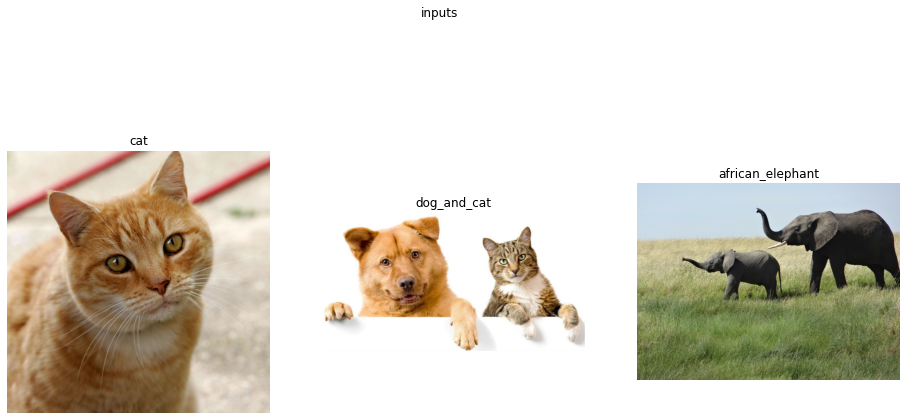

In [4]:
image_paths = glob.glob("./images/animals/*.*")
# elephant has RGBA idk why so need convert
images = list(map(lambda x: PIL.Image.open(x).convert("RGB"), image_paths))


plt.rcParams["figure.figsize"]= 16, 8
utils.subplot(
    images,
    title="inputs",
    rows_titles=["cat", "dog_and_cat", "african_elephant"],
    nrows=1,
    ncols=3,
)

## Transforms Params (ImageNet)

In [5]:
imagenet_mean: List[float] = [0.485, 0.456, 0.406]
imagenet_std: List[float] = [0.229, 0.224, 0.225]
image_size: int = 224

normalized_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

inverse_normalized_transform = torchvision.transforms.Compose(
    [utils.NormalizeInverse(mean=imagenet_mean, std=imagenet_std)]
)

In [6]:
# We use torchvision's transform to transform the cat image with resize and normalization.
# Note the tensors below should all be channels first!
cat_tensor = normalized_transform(images[0])
cat_and_dog_tensor = normalized_transform(images[1])
elephant_tensor = normalized_transform(images[2])

# Now feature_extractor expects batch_size x C x H x W, so we expand one dimension in the 0th dim  and put them on device
cat_tensor = cat_tensor.unsqueeze(dim=0).to(device)
cat_and_dog_tensor = cat_and_dog_tensor.unsqueeze(dim=0).to(device)
elephant_tensor = elephant_tensor.unsqueeze(dim=0).to(device)

In [7]:
# Construct an images_dict to store these tensors
images_dict: Dict[str, torch.Tensor] = {"cat": cat_tensor, "cat_and_dog": cat_and_dog_tensor, "elephant": elephant_tensor}

## Working with Torch Models

### Load the Models

In [8]:
alexnet_ = alexnet(pretrained=True).to(device)
vgg16_ = vgg16(pretrained=True).to(device)
resnet34_ = resnet34(pretrained=True).to(device)

### Torch Summary

We use a library to output the layer information like Keras's `model.summary()`.

We need to identify the last convolutional layer.

In [9]:
import torchsummary

def torchsummary_wrapper(
    model, image_size: Tuple[int, int, int]
) -> torchsummary.model_statistics.ModelStatistics:
    """A torch wrapper to print out layers of a Model.

    Args:
        model (CustomNeuralNet): Model.
        image_size (Tuple[int, int, int]): Image size as a tuple of (channels, height, width).

    Returns:
        model_summary (torchsummary.model_statistics.ModelStatistics): Model summary.
    """

    model_summary = torchsummary.summary(model, image_size)
    return model_summary

In [10]:
alexnet_model_summary = torchsummary_wrapper(alexnet_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          23,296
|    └─ReLU: 2-2                         [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]   

In [11]:
vgg16_model_summary = torchsummary_wrapper(vgg16_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

In [12]:
resnet34_model_summary = torchsummary_wrapper(resnet34_, image_size = (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

### Forward Backward Hooks

In [13]:
def forward_hook(
    module_name: str, forward_activations: Dict[str, torch.Tensor]
) -> Callable:
    """In-place forward hook to save activations of a layer.

    Args:
        module_name (str): The name of the layer to hook.
        forward_activations (Dict[str, torch.Tensor]): The dictionary to save the activations.

    Returns:
        forward_hook_: The forward hook function.
    """

    def forward_hook_(module, input, output):
        # Save forward feature map activations
        forward_activations[module_name] = output.detach()

    return forward_hook_


def backward_hook(
    module_name: str, backward_gradients: Dict[str, torch.Tensor]
) -> Callable:
    """In-place backward hook to save gradients of a layer.

    Args:
        module_name (str): The name of the layer to hook.
        backward_gradients (Dict[str, torch.Tensor]): The dictionary to save the gradients.

    Returns:
        Callable: The backward hook function.
    """

    def backward_hook_(module, grad_input, grad_output):
        # Save the gradients correspond to the feature maps
        # This will only be saved when backwards is called.
        backward_gradients[module_name] = grad_output[0].detach()

    return backward_hook_

### Saving Forward Activations and Backward Gradients

We define a function to get feature map activations and the model's backwards gradients.

In [14]:
def get_forward_activations_and_backward_gradients(
    model: Callable,
    image: torch.Tensor,
    target_category: Optional[int] = None,
) -> Union[List[Callable], Dict[str, torch.Tensor]]:
    """Get feature maps and gradients from a model.

    Args:
        model (Callable): A model.
        image (torch.Tensor): The input image.
        target_category (Optional[int], optional): The target category for the model to focus on. Defaults to None.

    Returns:
        handlers List[Callable]: A list of handlers.
        forward_activations Dict[str, torch.Tensor]: A dictionary of forward activations.
    """
    forward_activations = OrderedDict()
    backward_gradients = OrderedDict()

    handlers = []

    for name, module in model.named_modules():
        module_name = name + "_" + str(module)
        handlers.append(
            module.register_forward_hook(
                forward_hook(module_name, forward_activations)
            )
        )
        handlers.append(
            module.register_backward_hook(
                backward_hook(module_name, backward_gradients)
            )
        )

    model = model.eval()

    # the y_logits before softmax
    # forward pass to populate the forward_activations
    y_logits = model(image)

    if target_category is None:
        # get the most likely prediction of the model
        target_category = model(image).argmax(dim=1)
        # convert to scalar
        target_category = target_category.item()

    # call backward on the model to populate backward_gradients
    y_logits[:, target_category].backward()

    return handlers, forward_activations, backward_gradients

## Grad-CAM 

### Storing Forward Activations and Backward Gradients

This part is the same as Saving Forward Activations and Backward Gradients.

In [17]:
def get_forward_activations_and_backward_gradients(
    model: Callable,
    image: torch.Tensor,
    target_category: Optional[int] = None,
) -> Union[List[Callable], Dict[str, torch.Tensor]]:
    """Get feature maps and gradients from a model.

    Args:
        model (Callable): A model.
        image (torch.Tensor): The input image.
        target_category (Optional[int], optional): The target category for the model to focus on. Defaults to None.

    Returns:
        handlers List[Callable]: A list of handlers.
        forward_activations Dict[str, torch.Tensor]: A dictionary of forward activations.
    """
    forward_activations = OrderedDict()
    backward_gradients = OrderedDict()

    handlers = []

    for name, module in model.named_modules():
        module_name = name + "_" + str(module)
        handlers.append(
            module.register_forward_hook(
                forward_hook(module_name, forward_activations)
            )
        )
        handlers.append(
            module.register_backward_hook(
                backward_hook(module_name, backward_gradients)
            )
        )

    model = model.eval()

    # the y_logits before softmax
    # forward pass to populate the forward_activations
    y_logits = model(image)

    if target_category is None:
        # get the most likely prediction of the model
        target_category = model(image).argmax(dim=1)
        # convert to scalar
        target_category = target_category.item()

    # call backward on the model to populate backward_gradients
    y_logits[:, target_category].backward()

    return handlers, forward_activations, backward_gradients

### Grad-CAM Heatmap Function

In [18]:
def compute_gradcam_localization_heatmap(
    target_layer_name: str,
    forward_activations: Dict[str, torch.Tensor],
    backward_gradients: Dict[str, torch.Tensor],
) -> torch.Tensor:
    """Compute GradCAM for a specific target layer.

    Args:
        target_layer_name (str): The name of the target layer. Usually the last convolutional layer.
        forward_activations (Dict[str, torch.Tensor]): The forward activations of the model. A dictionary of activations.
        backward_gradients (Dict[str, torch.Tensor]): The backward gradients of the model. A dictionary of gradients.

    Returns:
        gradcam_heatmap (torch.Tensor): The heatmap of the GradCAM.
    """
    # get the activations of the last convolutional layer
    forward_conv_activations = forward_activations[target_layer_name]
    dyc_dA = backward_gradients[target_layer_name]
    
    # average pool the gradients across the channels
    global_average_pooled_gradients = torch.mean(dyc_dA, dim=[0, 2, 3])

    num_feature_maps = forward_conv_activations.squeeze().shape[0]

    weighted_localization_map = torch.clone(forward_conv_activations)

    # weight the channels by corresponding gradients
    for i in range(num_feature_maps):
        weighted_localization_map[
            :, i, :, :
        ] *= global_average_pooled_gradients[i]

    # sum the channels of the activations
    weighted_localization_map = torch.sum(
        weighted_localization_map, dim=1
    ).squeeze()
    
    # relu on top of the heatmap expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    relu_weighted_localization_map = torch.nn.ReLU(inplace=False)(
        weighted_localization_map
    )
    # normalize the heatmap, scale features to between 0 and 1 to plot
    gradcam_heatmap = relu_weighted_localization_map / torch.max(
        relu_weighted_localization_map
    )

    # draw the heatmap
    plt.rcParams["figure.figsize"] = 16, 8
    plt.matshow(gradcam_heatmap.squeeze())
    return gradcam_heatmap

### SuperImpose Image

Superimpose heatmap to original image.

In [ ]:
def display_gradcam(
    image: torch.Tensor,
    gradcam_heatmap: torch.Tensor,
    alpha=1.0,
):
    """Display the GradCAM heatmap.

    Args:
        image (torch.Tensor): _description_
        gradcam_heatmap (torch.Tensor): _description_
        alpha (float, optional): _description_. Defaults to 0.8.
    """
    # step 1: Unnormalize the input image to be between 0 and 1, and multiply to become within 255
    # squeeze dimensions when there is 1. because [1, 3, 224, 224] is [3, 224, 224]
    # shape = (3, 224, 224)

    original_image_unnormalized = inverse_normalized_transform(
        image.squeeze().cpu()
    )
    original_image_unnormalized = original_image_unnormalized * 255

    # step 2: make CxHxW to HxWxC and convert to numpy

    original_image_unnormalized = original_image_unnormalized.permute(
        1, 2, 0
    ).numpy()

    # step 3: Normalize the heatmap to between 0 and 1 and resize it to the image size we want, then multiply to within 255

    # first make it into numpy
    gradcam_heatmap = gradcam_heatmap.detach().cpu().numpy()
    h, w, c = original_image_unnormalized.shape

    # normalize and resize
    gradcam_heatmap -= np.min(gradcam_heatmap)
    gradcam_heatmap /= np.max(gradcam_heatmap)  # Normalize between 0-1
    gradcam_heatmap = cv2.resize(gradcam_heatmap, (w, h))

    gradcam_heatmap = np.uint8(gradcam_heatmap * 255.0)

    # step 4: Apply color maps and overlay the heatmap on the original image to get superimposed image

    gradcam_heatmap = cv2.applyColorMap(gradcam_heatmap, cv2.COLORMAP_JET)
    gradcam_heatmap = cv2.cvtColor(gradcam_heatmap, cv2.COLOR_BGR2RGB)
    superimposed_image = gradcam_heatmap * alpha + original_image_unnormalized

    superimposed_image /= np.max(superimposed_image)

    # step 5: Display the image
    plt.rcParams["figure.figsize"] = 16, 8
    plt.imshow(superimposed_image)
    return superimposed_image

### Alexnet Gradcam

In [19]:
_, f_alexnet, b_alexnet = get_forward_activations_and_backward_gradients(alexnet_, image=images_dict["cat"], target_category=None)

C:\Users\reighns\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


For this model, the last layer can be `alexnet_.features.11`. In our case it is `features.11_ReLU(inplace=True)`.

In [20]:
target_layer_name = "features.11_ReLU(inplace=True)"

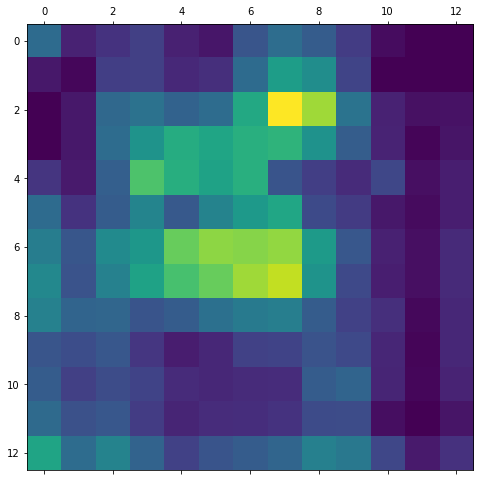

In [21]:
alexnet_gradcam_heatmap = compute_gradcam_localization_heatmap(target_layer_name, f_alexnet, b_alexnet)

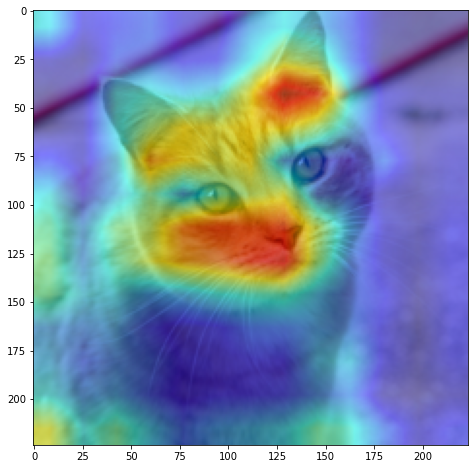

In [23]:
_ = display_gradcam(
    image=images_dict["cat"], gradcam_heatmap=alexnet_gradcam_heatmap, alpha=1.0
)

### VGG16 Gradcam

In [24]:
_, f_vgg16, b_vgg16 = get_forward_activations_and_backward_gradients(vgg16_, image=images_dict["cat"], target_category=None)

For this model, the last layer can be `alexnet_.features.12`. In our case it is `features.12_MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)`.

In [25]:
target_layer_name = "features.29_ReLU(inplace=True)"

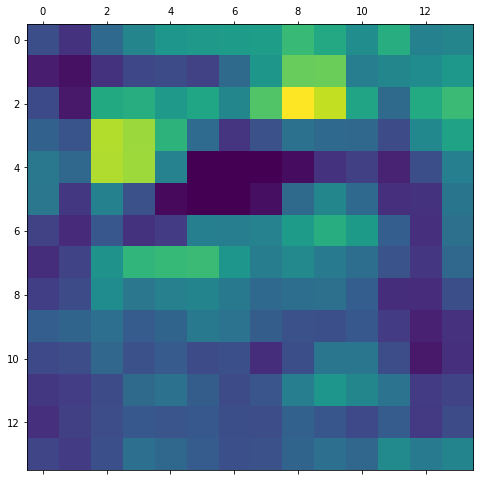

In [26]:
vgg16_gradcam_heatmap = compute_gradcam_localization_heatmap(target_layer_name, f_vgg16, b_vgg16)

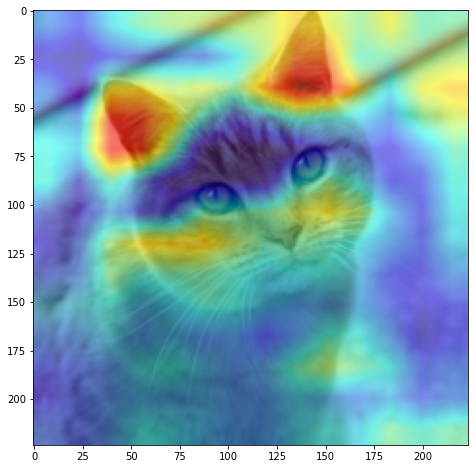

In [27]:
_ = display_gradcam(
    image=images_dict["cat"], gradcam_heatmap=vgg16_gradcam_heatmap, alpha=1.0
)

### VGG16 Grad-CAM with Target Category

If we specifically pass into a target category, where 285 is cat and 260 is dog, we see the model sees different things!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


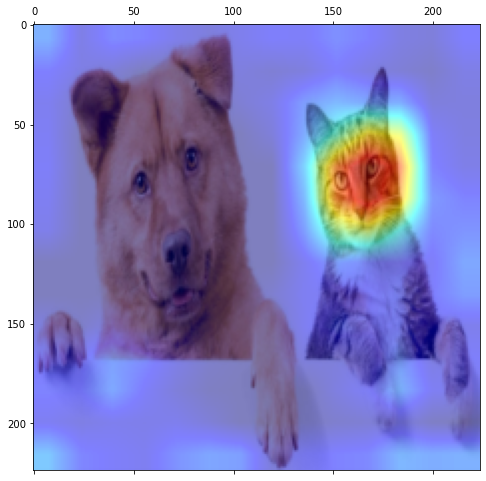

In [28]:
_, f_vgg16, b_vgg16 = get_forward_activations_and_backward_gradients(vgg16_, image=images_dict["cat_and_dog"], target_category=285)
target_layer_name = "features.29_ReLU(inplace=True)"
vgg16_gradcam_heatmap = compute_gradcam_localization_heatmap(target_layer_name, f_vgg16, b_vgg16)

_ = display_gradcam(
    image=images_dict["cat_and_dog"], gradcam_heatmap=vgg16_gradcam_heatmap, alpha=1.0
)

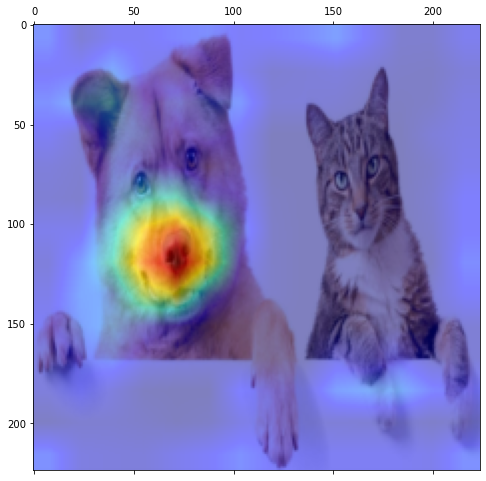

In [29]:
_, f_vgg16, b_vgg16 = get_forward_activations_and_backward_gradients(vgg16_, image=images_dict["cat_and_dog"], target_category=260)
target_layer_name = "features.29_ReLU(inplace=True)"
vgg16_gradcam_heatmap = compute_gradcam_localization_heatmap(target_layer_name, f_vgg16, b_vgg16)

_ = display_gradcam(
    image=images_dict["cat_and_dog"], gradcam_heatmap=vgg16_gradcam_heatmap, alpha=1.0
)

## Out of the Box Library

In [30]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, vgg19, resnet34

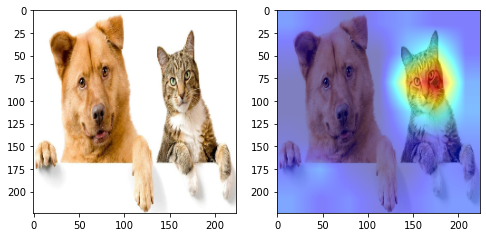

In [31]:
dog_and_cat_path = "./images/animals/dog_and_cat.jpg"
image = cv2.imread(dog_and_cat_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# needed for gradcam.
original_image = cv2.resize(image, (224, 224))


model = vgg16(pretrained=True)
target_layers = [model.features[-1]]
input_tensor = images_dict["cat_and_dog"] # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
target_category = 285

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]


image_normalized = original_image / 255.
visualization = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)

_fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
axes[0].imshow(image_normalized)

axes[1].imshow(visualization)

plt.show()
torch.cuda.empty_cache()

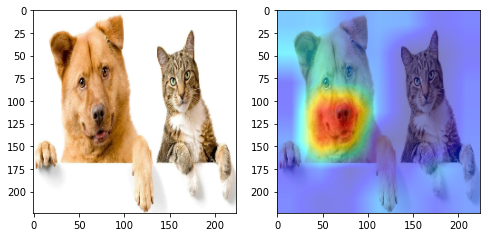

In [32]:
dog_and_cat_path = "./images/animals/dog_and_cat.jpg"
image = cv2.imread(dog_and_cat_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# needed for gradcam.
original_image = cv2.resize(image, (224, 224))


model = vgg16(pretrained=True)
target_layers = [model.features[-1]]
input_tensor = images_dict["cat_and_dog"] # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
target_category = 260

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]


image_normalized = original_image / 255.
visualization = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)

_fig, axes = plt.subplots(figsize=(8, 8), ncols=2)
axes[0].imshow(image_normalized)

axes[1].imshow(visualization)

plt.show()
torch.cuda.empty_cache()